In [1]:
from functools import partial

import numpy as np
import pandas as pd
import scipy.stats as sts

import arviz as av
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import mcx
import mcx.distributions as dist

# sns.set_style("darkgrid")
# Trigger the warning about missing GPUs
jnp.ones(1);

# Code 3.1

In [2]:
p_positive_vampire = 0.95
p_positive_mortal  = 0.01
p_vampire = 0.001

p_positive = (
    p_positive_vampire * p_vampire 
    + p_positive_mortal * (1 - p_vampire)
)
p_positive

0.01094

$$
P(V | +) = \frac{P(+ | V) \cdot P(V)}{P(+)}
$$

In [3]:
p_vampire_positive = (
    p_positive_vampire * p_vampire
    / p_positive
)

p_vampire_positive

0.08683729433272395

# Code 3.2

In [4]:
rng_key = jax.random.PRNGKey(0)
tosses = "WLWWWLWLW"
grid_size = 10000

In [5]:
def get_globe_tossing_posterior(tosses: str, grid_size: int, key: jax.random.PRNGKey):
    
    n = len(tosses)
    k = tosses.count("W")

    p_grid = jnp.linspace(0, 1, grid_size)
    p_prior = jnp.ones(grid_size) / grid_size

    binom = dist.Binomial(n=n, p=p_grid)
    likelihood = jnp.exp(binom.logpdf(k))

    posterior = p_prior * likelihood
    posterior /= posterior.sum()

    return p_grid, posterior

In [6]:
p_grid, posterior = get_globe_tossing_posterior(tosses, grid_size, rng_key)

# Code 3.3

In [7]:
samples = jax.random.choice(
    a=p_grid, 
    p=posterior,
    shape=(10_000, ), 
    key=rng_key, 
)

# Figure 3.1

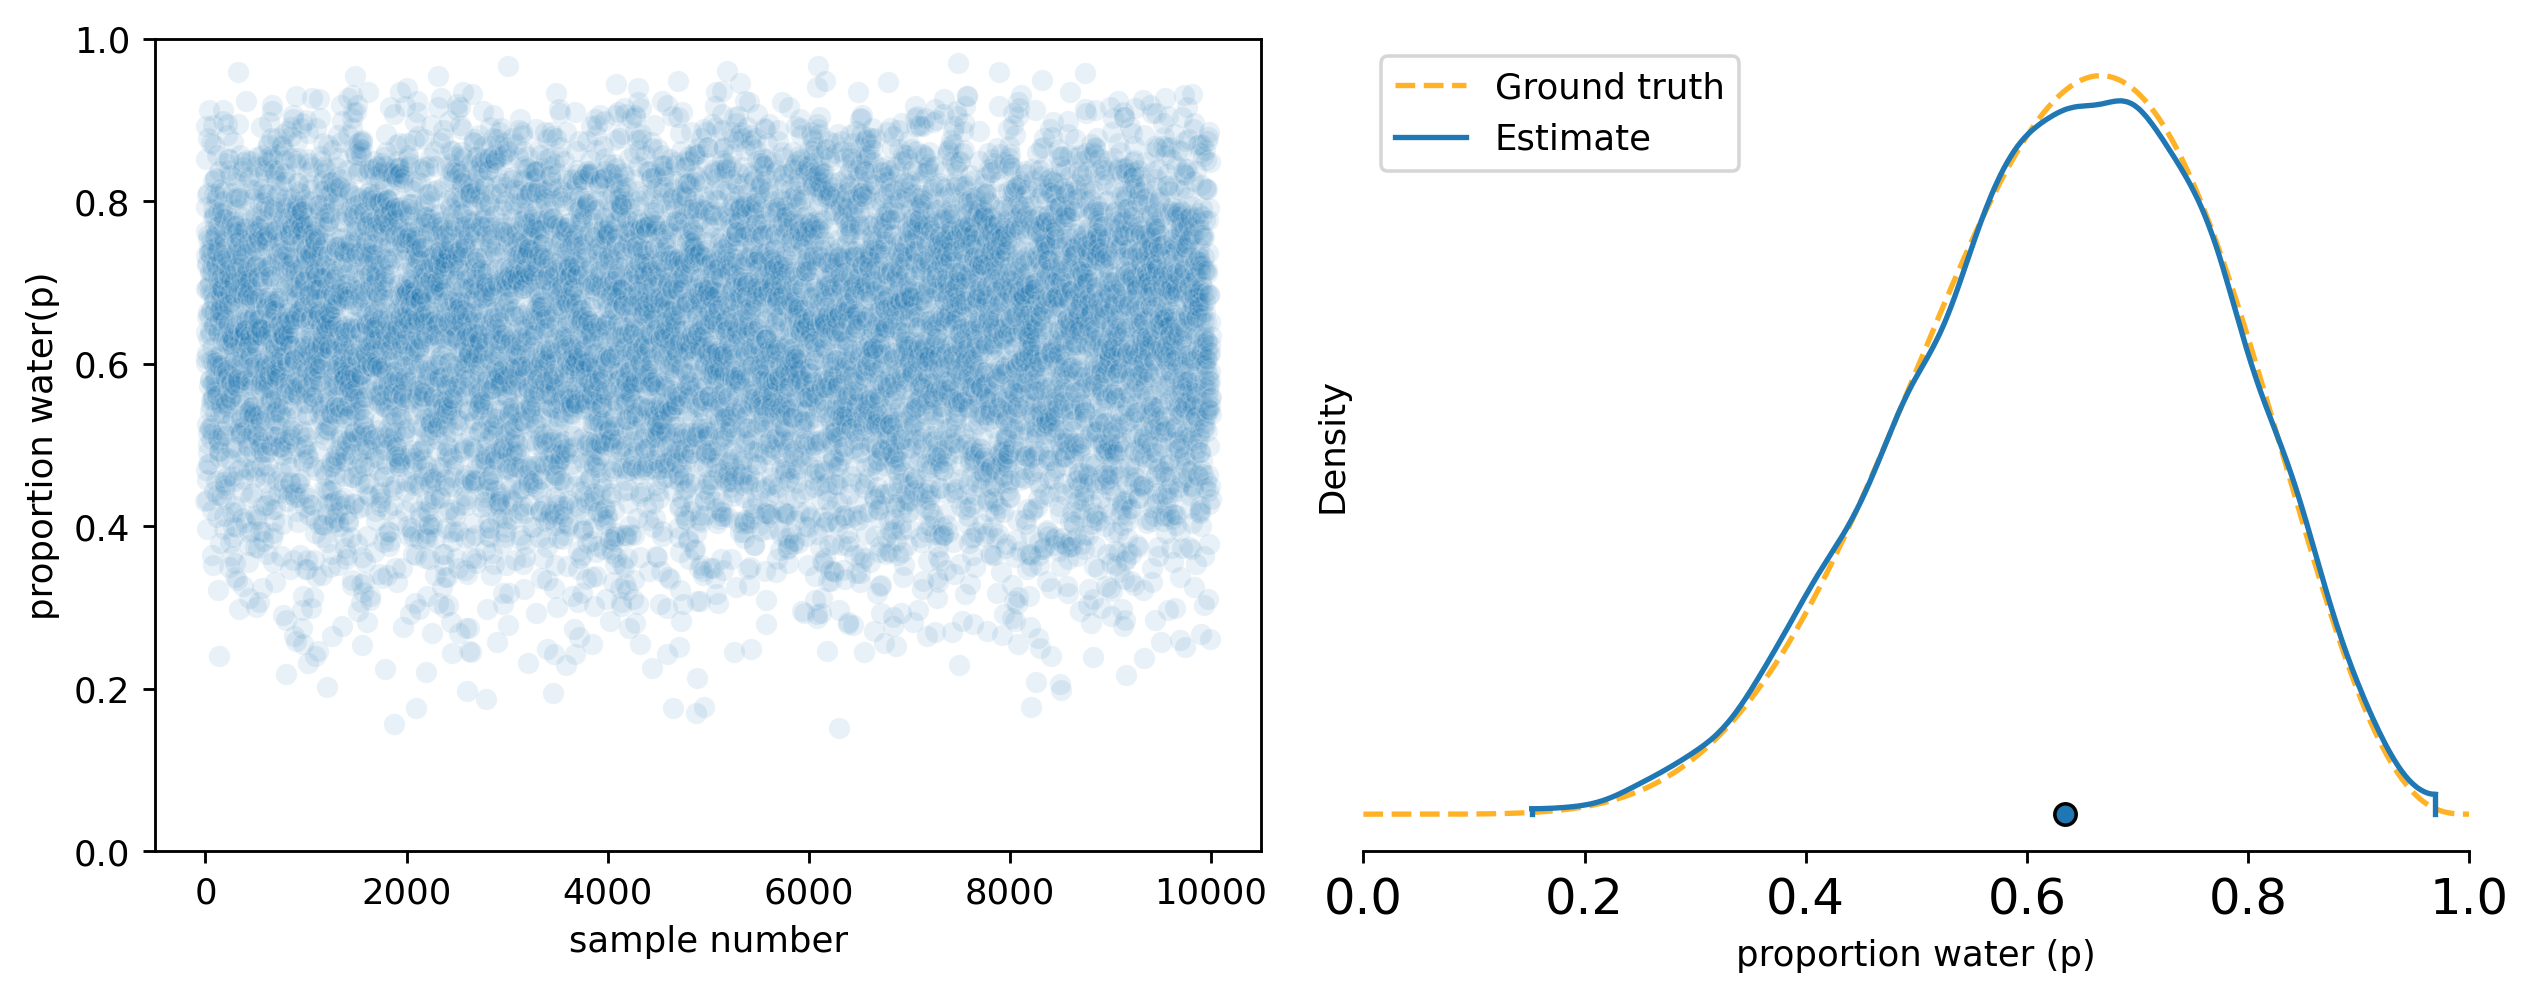

In [8]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=256)

ax0 = sns.scatterplot(x=jnp.arange(10_000), y=samples, alpha=0.1, ax=ax0)
ax0.set_ylim(0., 1.)
ax0.set_ylabel("proportion water(p)")
ax0.set_xlabel("sample number");

# Not shown in the original figure
ax1 = sns.lineplot(
    x=p_grid, 
    y=posterior * grid_size, 
    alpha=0.85, 
    color="orange", 
    linestyle="--", 
    ax=ax1
)

ax1 = av.plot_density({"": samples}, hdi_prob=1, ax=ax1)
ax1.set_xlim(0., 1.)
ax1.set_ylabel("Density")
ax1.set_xlabel("proportion water (p)");

ax1.legend(["Ground truth", "Estimate"])
plt.tight_layout()

# Code 3.6

In [9]:
mask = p_grid < 0.5
posterior[mask].sum()

DeviceArray(0.171875, dtype=float32)

# Code 3.7

In [10]:
(samples < 0.5).mean()

DeviceArray(0.179, dtype=float32)

# Code 3.8

In [11]:
((samples > 0.5) & (samples < 0.75)).mean()

DeviceArray(0.5961, dtype=float32)

# Code 3.9

In [12]:
pd.Series(samples).quantile(0.8)

0.7609960794448853

# Code 3.10

In [13]:
pd.Series(samples).quantile([0.1, 0.9])

0.1    0.442824
0.9    0.813681
dtype: float64

# Figure 3.2

In [14]:
def plot_posterior_interval(p_grid: jnp.DeviceArray, posterior: jnp.DeviceArray, mask: jnp.DeviceArray, ax):
    
    ax = sns.lineplot(x=p_grid, y=posterior, ax=ax)
    ax.fill_between(p_grid[mask], posterior[mask], alpha=0.5)
    
    return ax

In [15]:
rng_key = jax.random.PRNGKey(0)
tosses = "WLWWWLWLW"
grid_size = 10000

p_grid, posterior = get_globe_tossing_posterior(tosses, grid_size, rng_key)

_plot_fn = partial(plot_posterior_interval, p_grid=p_grid, posterior=posterior)

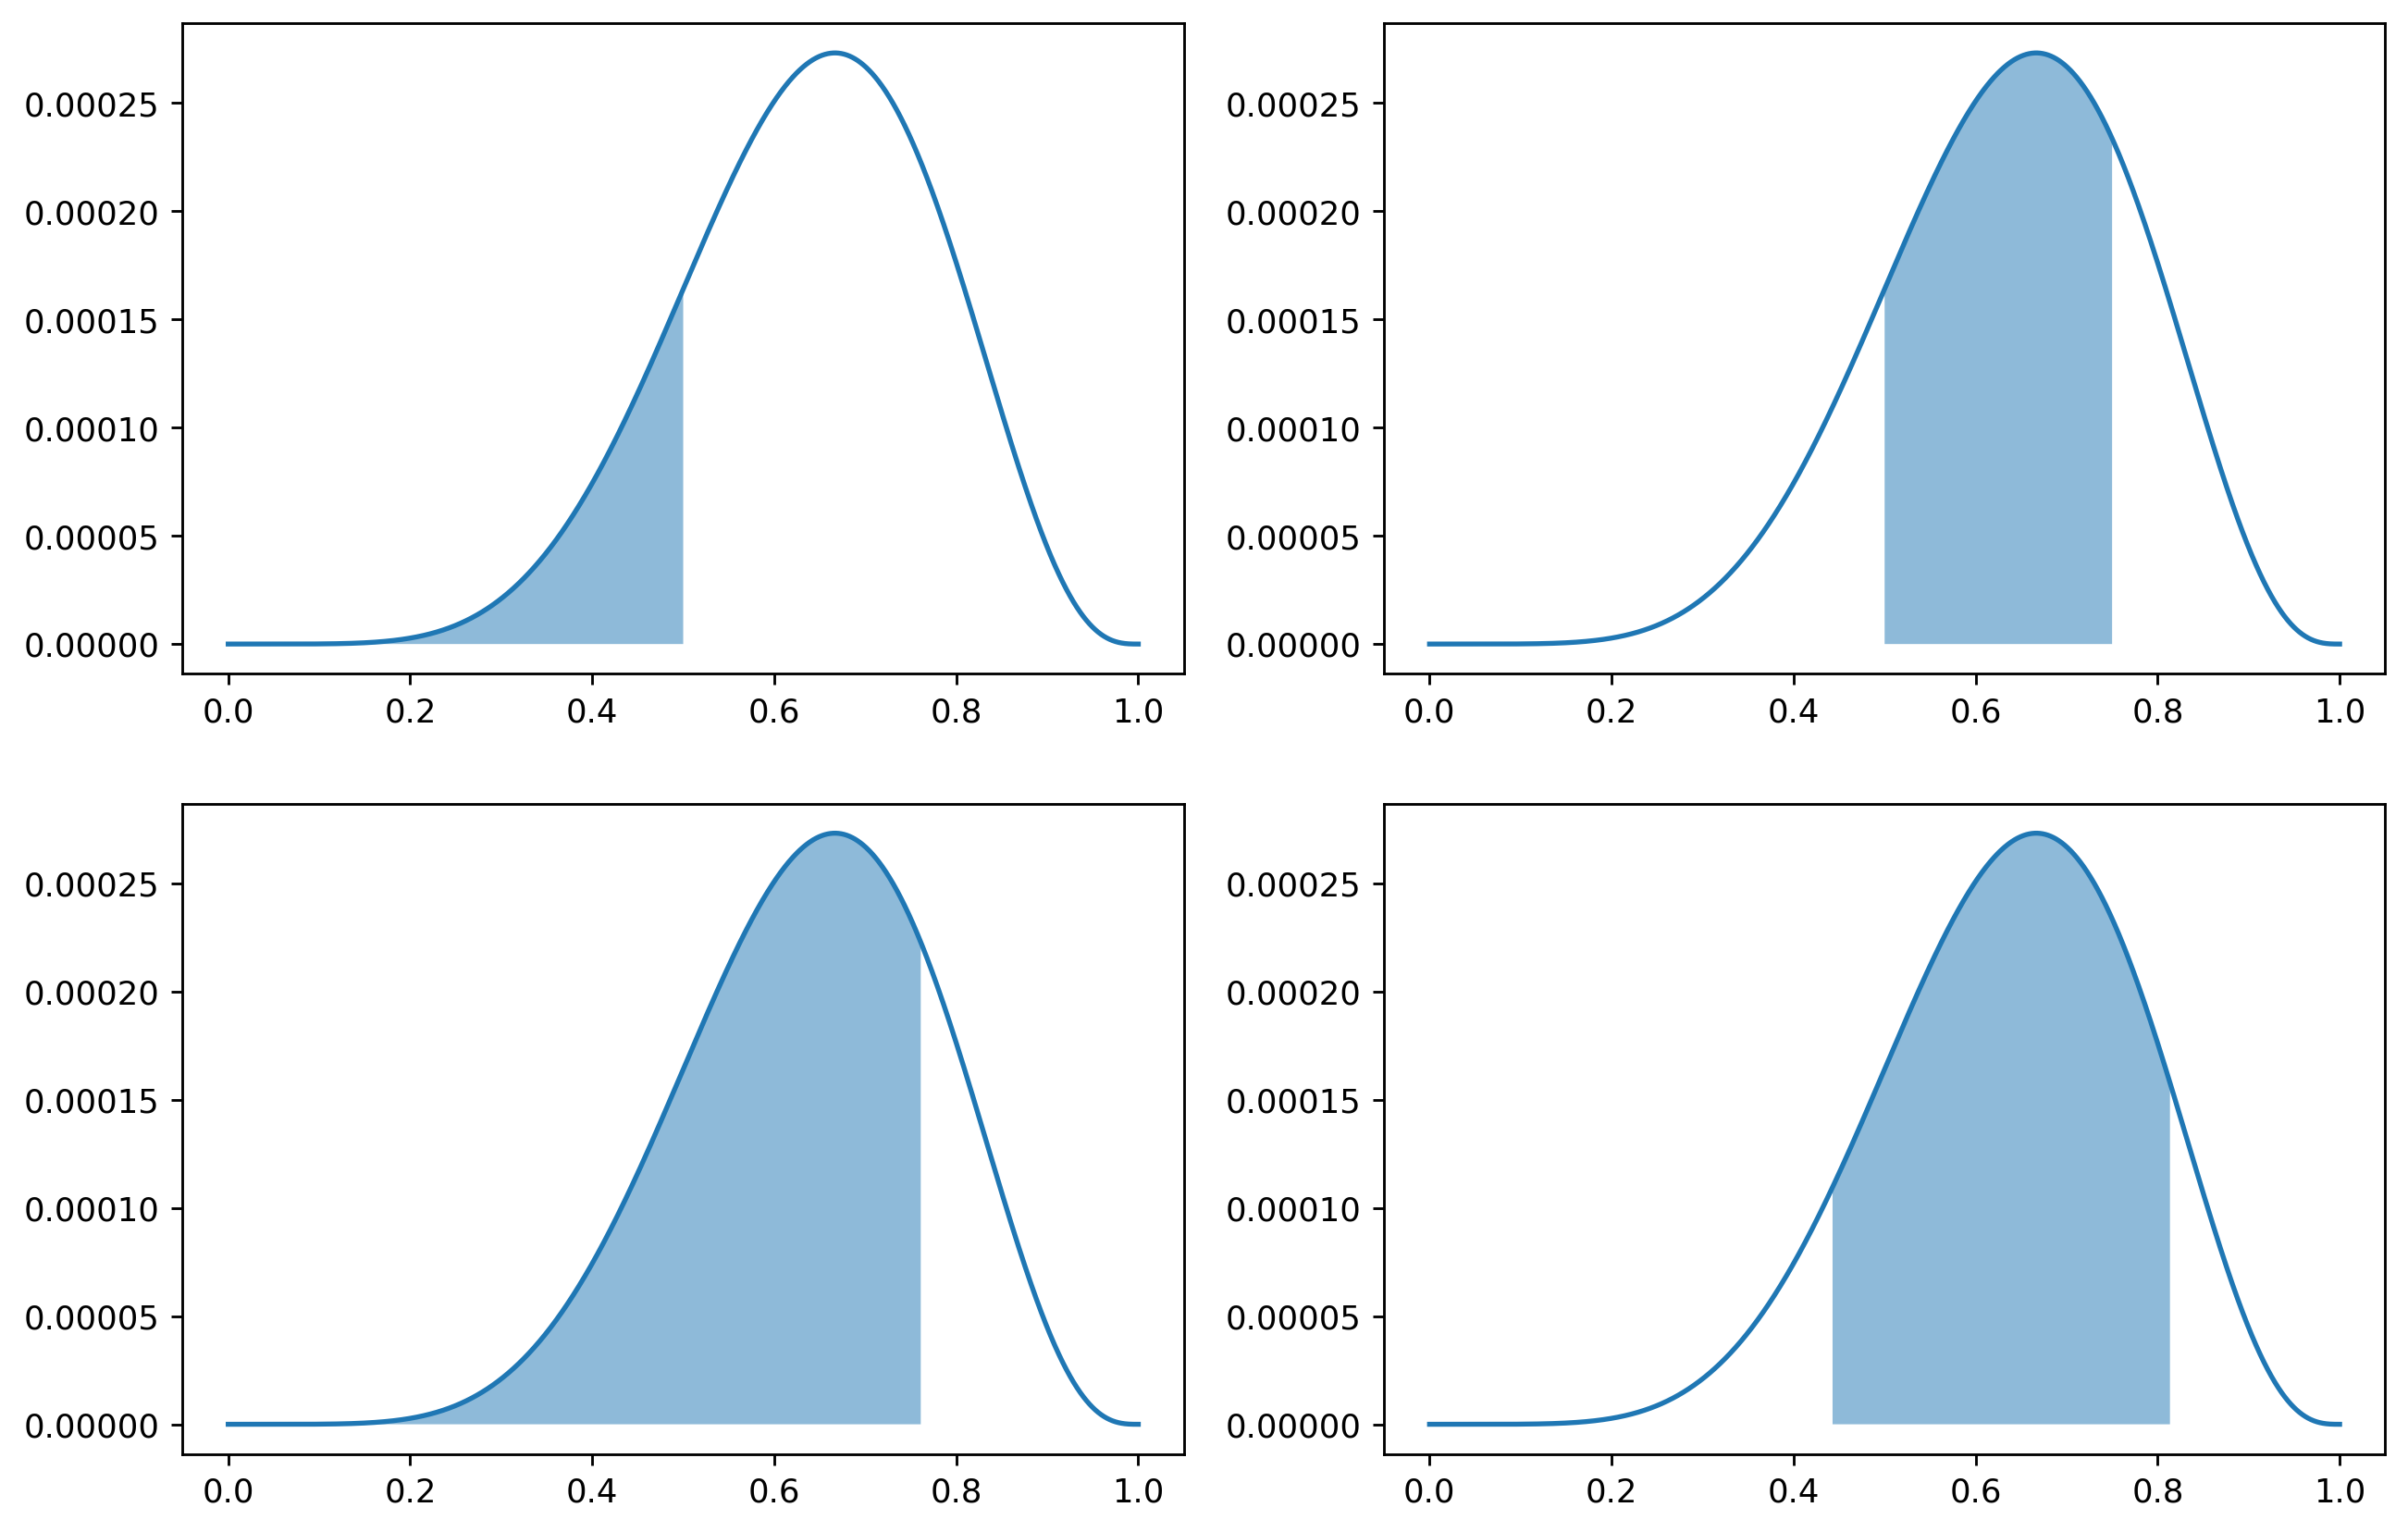

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=256)
((ax0, ax1), (ax2, ax3)) = axes

# TOP-LEFT
mask = (p_grid < 0.5)
_plot_fn(mask=mask, ax=ax0)

# TOP-RIGHT
mask = (p_grid > 0.5)
mask = mask & (p_grid < 0.75)
_plot_fn(mask=mask, ax=ax1)

# BOTTOM-LEFT
q = pd.Series(samples).quantile(0.8)
mask = (p_grid < q)
_plot_fn(mask=mask, ax=ax2)

# BOTTOM-RIGHT
q0, q1 = pd.Series(samples).quantile([0.1, 0.9])
mask = (p_grid > q0) & (p_grid < q1)
_plot_fn(mask=mask, ax=ax3);

# Code 3.11

In [17]:
tosses = "WWW"
n = len(tosses)
k = tosses.count("W")

p_grid, posterior = get_globe_tossing_posterior(tosses, 10_000, rng_key)

In [18]:
samples = jax.random.choice(
    a=p_grid, 
    p=posterior,
    shape=(100_000, ), 
    key=rng_key, 
)

In [19]:
pd.Series(samples).quantile([0.25, 0.75])

0.25    0.706071
0.75    0.930193
dtype: float64

# Figure 3.3 -- manually calcuated HPDI

In [20]:
def naive_hpdi(samples, size: float = 0.95):
    """ Brute-Force calculation of the Highest Posterior Density Interval 
    """
    
    s = np.array(samples)
    n = len(samples)
    indices  = np.argsort(s)
    s_sorted = np.sort(s)

    step = int(size * n)
    best = float("inf")
    i, j = None, None
    
    for idx in range(n - step):
        d = s_sorted[idx + step] - s_sorted[idx]
        if d < best:
            best = d
            i, j = idx, idx + step
        
    low = s_sorted[i]
    high = s_sorted[j]
    
    return low, high
        

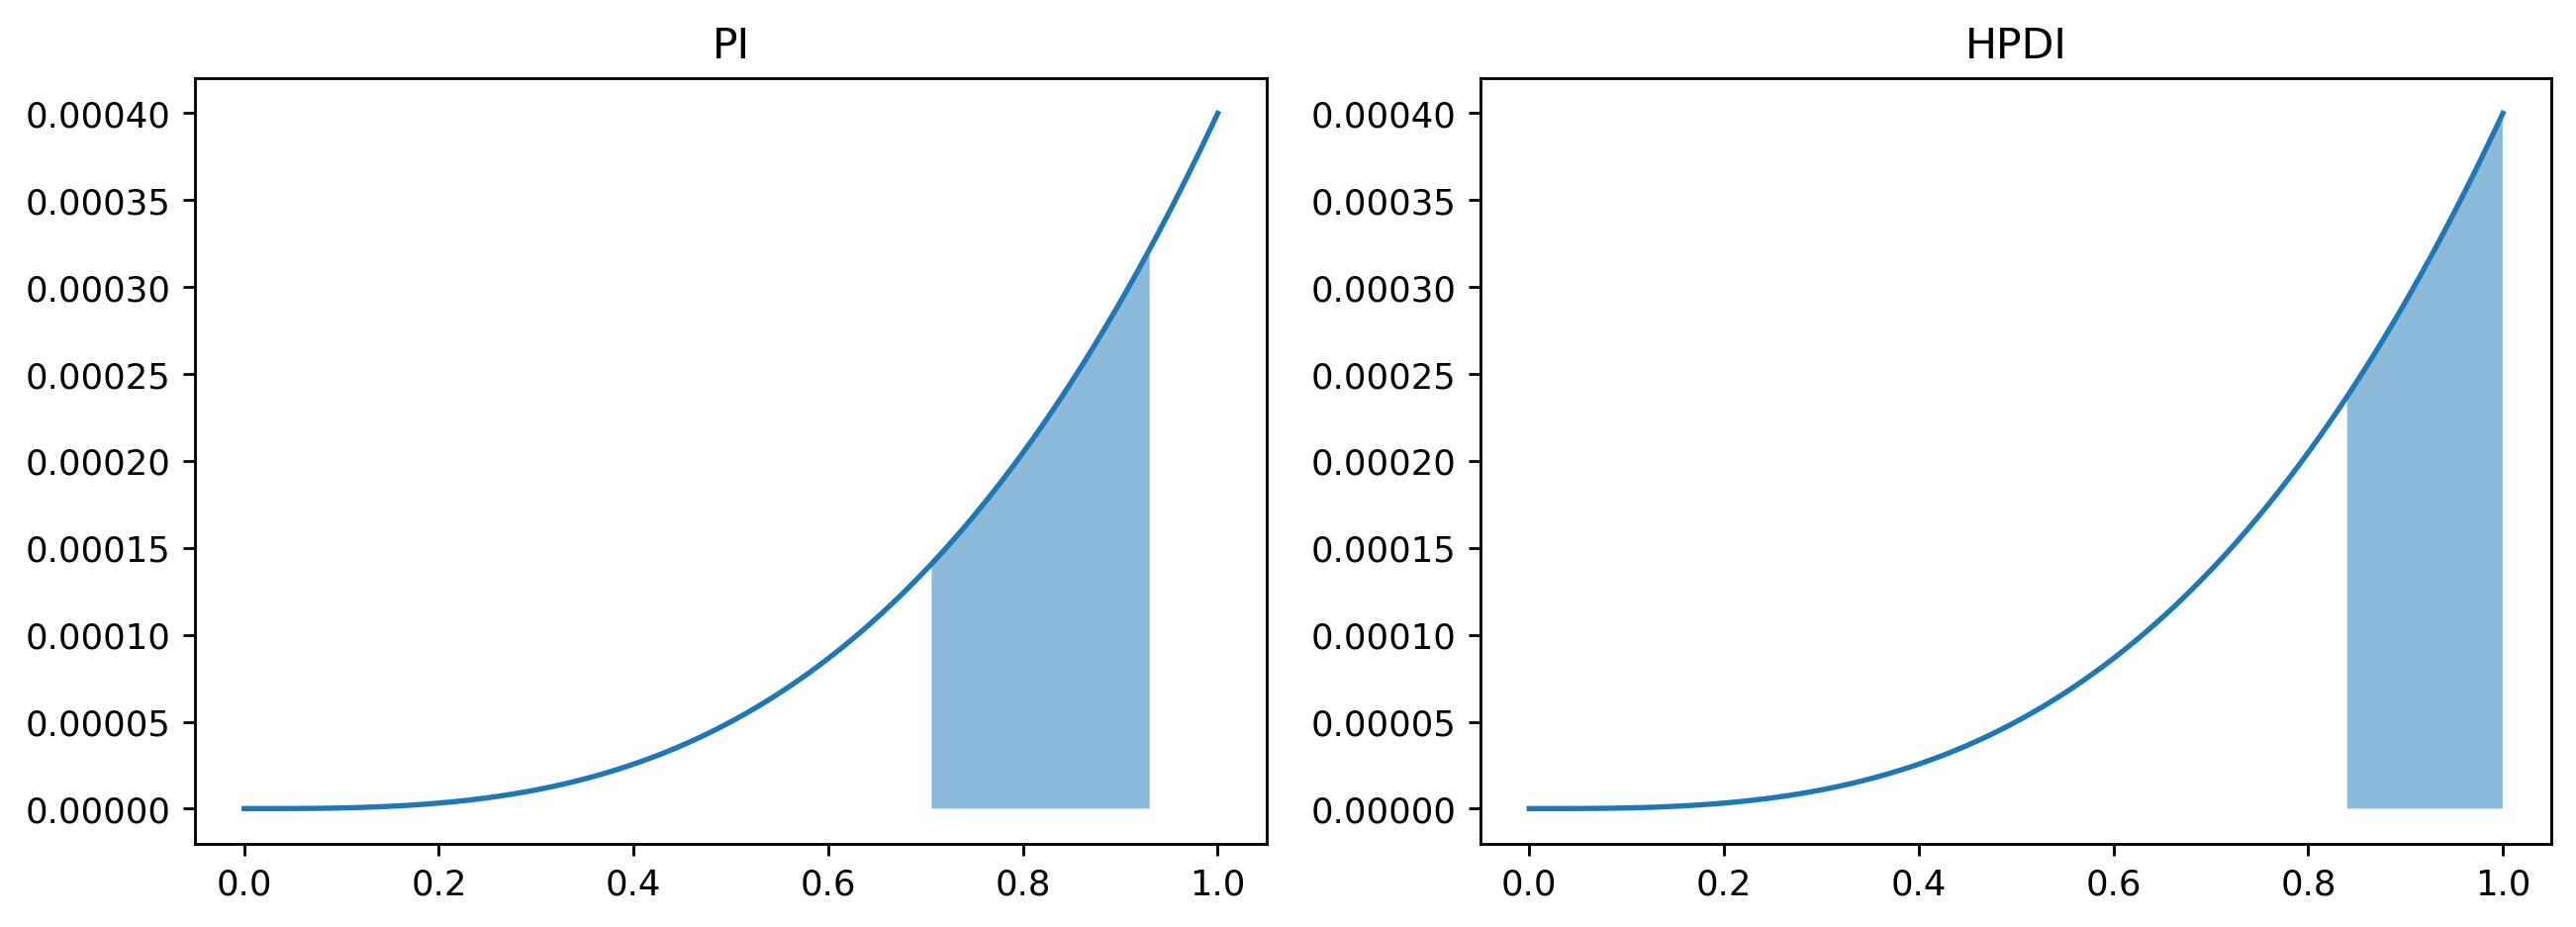

In [21]:
_plot_fn = partial(plot_posterior_interval, p_grid=p_grid, posterior=posterior)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), dpi=256)

# PI
low, high = pd.Series(samples).quantile([0.25, 0.75])
mask = (p_grid > low) & (p_grid < high)
ax0 = _plot_fn(mask=mask, ax=ax0)
_ = ax0.set_title("PI")

# HPDI
low, high = naive_hpdi(samples, 0.5)
mask = (p_grid > low) & (p_grid < high)
ax0 = _plot_fn(mask=mask, ax=ax1)
_ = ax1.set_title("HPDI")

`TODO`: is there a way to create similar plots with `arviz`?

# Code 3.12

In [22]:
pd.Series(samples).quantile([0.25, 0.75])

0.25    0.706071
0.75    0.930193
dtype: float64

# Code 3.13

In [23]:
naive_hpdi(samples, 0.5)

(0.839984, 0.9999)

# Code 3.14

In [24]:
mode = float(
    p_grid[jnp.argmax(posterior)]
)

mode

1.0

# Code 3.15

In [25]:
kde = sts.gaussian_kde(samples, bw_method=0.01)
density = kde.evaluate(p_grid)

p_grid[np.argmax(density)]

DeviceArray(0.9942994, dtype=float32)

# Code 3.16

In [26]:
mean = float(
    jnp.mean(samples)
)

mean

0.7993041276931763

In [27]:
median = float(
    jnp.median(samples)
)

median

0.8400840163230896

# Code 3.17

In [28]:
jnp.sum(posterior * jnp.abs(0.5 - p_grid))

DeviceArray(0.3125375, dtype=float32)

# Code 3.18

In [29]:
cost = jnp.abs((p_grid[:, None] - p_grid[None, :]))
loss = (posterior * cost).sum(1)

# Code 3.19

In [30]:
best = float(p_grid[jnp.argmin(loss)])
best

0.8409841060638428

# Figure 3.4

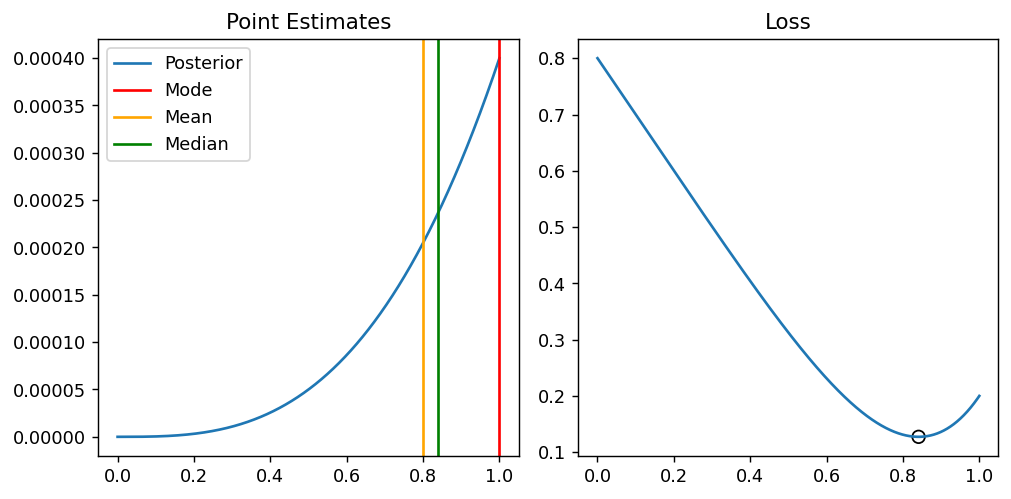

In [31]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4), dpi=128)

ax0 = sns.lineplot(x=p_grid, y=posterior, ax=ax0)
ax0.axvline(mode, color="red")
ax0.axvline(mean, color="orange")
ax0.axvline(median, color="green")


ax1 = sns.lineplot(
    x=np.array(p_grid), 
    y=np.array(loss), 
    ax=ax1
)

ax1.scatter(
    [best], 
    [float(jnp.min(loss))],
    s=50,
    facecolors="none",
    edgecolors="black",
)

ax0.set_title("Point Estimates")
ax1.set_title("Loss")
ax0.legend(["Posterior", "Mode", "Mean", "Median"])
plt.tight_layout()

# Code 3.20

In [32]:
sts.binom(n=2, p=0.7).pmf([0, 1, 2])

array([0.09, 0.42, 0.49])

# Code 3.21

In [33]:
sts.binom(n=2, p=0.7).rvs()

2

# Code 3.22

In [34]:
sts.binom(n=2, p=0.7).rvs(10)

array([2, 2, 2, 2, 1, 2, 1, 1, 2, 2])

# Code 3.23

In [35]:
dummy_w = sts.binom(n=2, p=0.7).rvs(10_000)
values, counts = np.unique(dummy_w, return_counts=True)
counts / counts.sum()

array([0.0915, 0.4206, 0.4879])

# Code 3.24 & Figure 3.5

In [36]:
dummy_w = sts.binom(n=9, p=0.7).rvs(10_000)

In [37]:
def simple_hist(samples, ax, color: str = ".2"):
    
    values, counts = np.unique(samples, return_counts=True)    

    ax = sns.barplot(
        x=values, 
        y=counts, 
        color=color,
        ax=ax, 
    )
    
    return ax

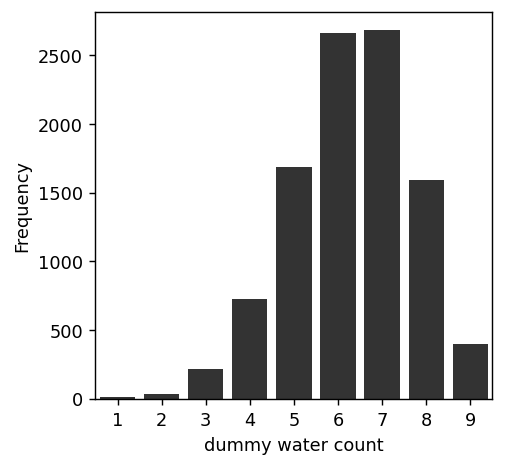

In [38]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=128)
ax = simple_hist(dummy_w, ax=ax)

ax.set_xlabel("dummy water count")
ax.set_ylabel("Frequency");

# Code 3.25

In [39]:
w_3_25 = sts.binom(n=9, p=0.6).rvs(10_000)

# Code 3.26

In [40]:
tosses = "WLWWWLWLW"
grid_size = 10000

p_grid, posterior = get_globe_tossing_posterior(tosses, grid_size, rng_key)

samples = jax.random.choice(
    a=p_grid, 
    p=posterior,
    shape=(10_000, ), 
    key=rng_key, 
)

In [41]:
w_3_26 = sts.binom(n=9, p=samples).rvs(len(samples))

# Figure 3.6 (sort of)

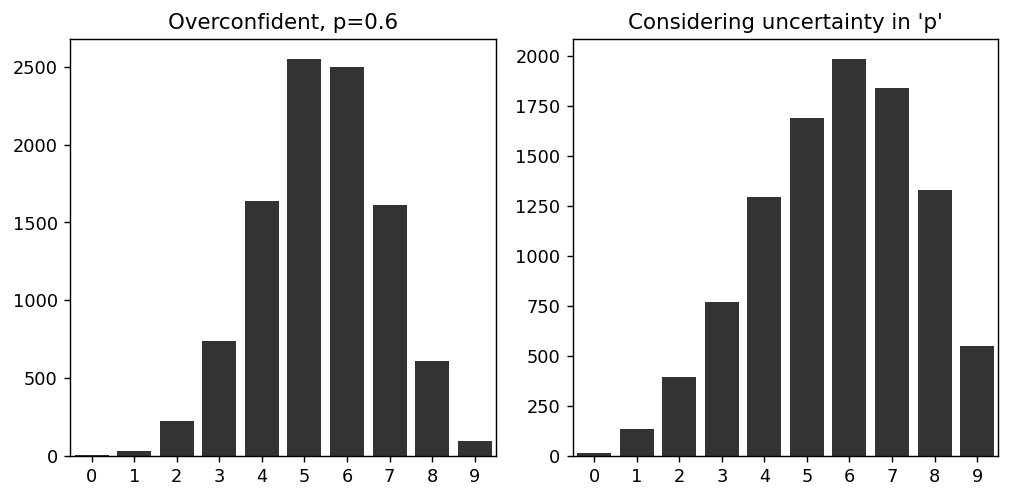

In [42]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4), dpi=128)

ax0 = simple_hist(w_3_25, ax=ax0)
ax1 = simple_hist(w_3_26, ax=ax1)

ax0.set_title("Overconfident, p=0.6")
ax1.set_title("Considering uncertainty in 'p'")

plt.tight_layout()

# Figure 3.7

In [43]:
simulated_tosses = np.concatenate(
    [sts.bernoulli(p=samples).rvs(len(samples)) for _ in range(9)]
)

simulated_tosses = simulated_tosses.reshape(-1, 9)
simulated_tosses = 2 * simulated_tosses - 1
simulated_tosses

array([[-1,  1,  1, ...,  1, -1,  1],
       [ 1,  1, -1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -1,  1, -1],
       ...,
       [-1,  1,  1, ...,  1, -1,  1],
       [ 1,  1, -1, ...,  1, -1,  1],
       [-1,  1, -1, ...,  1,  1,  1]])

In [44]:
def longest_run(tosses):

    n, m = tosses.shape
    ret = np.zeros(n, dtype=np.int64)

    for i in range(n):
        
        best, current = 0, 0
        
        for j in range(m):
            if tosses[i, j] == 1:
                current += 1
            else:
                best = max(current, best)
                current = 1
    
        ret[i] = best
    
    return ret

In [45]:
%%time 

n_switches = (np.diff(simulated_tosses, axis=1) != 0).sum(1)
n_consecutive = longest_run(simulated_tosses)

CPU times: user 64.9 ms, sys: 0 ns, total: 64.9 ms
Wall time: 64.3 ms


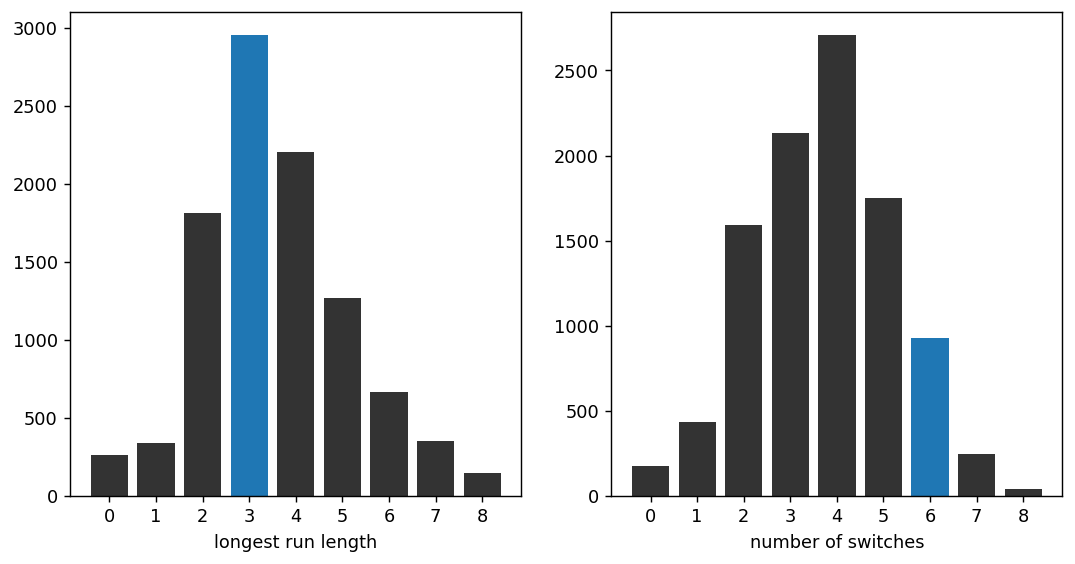

In [46]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5), dpi=128)

ax0 = simple_hist(n_consecutive, ax=ax0)
ax0.bar(
    x=[3], 
    height=[(n_consecutive == 3).sum()]
);
ax0.set_xlabel("longest run length")

ax1 = simple_hist(n_switches, ax=ax1)
ax1.bar(
    x=[6], 
    height=[(n_switches == 6).sum()]
);
ax1.set_xlabel("number of switches");